In [2]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [ ]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

# Aproximamiento probabilisitco en determinar clases



         date  portfolio_return  n_stocks  cumulative_return
0  2003-03-31          0.657577      56.0           1.657577
1  2004-03-31          0.126405      89.0           1.867104
2  2005-03-31          0.232191      89.0           2.300629
3  2006-03-31          0.079604      93.0           2.483769
4  2007-03-31         -0.035997      44.0           2.394361
5  2008-03-31         -0.321402      83.0           1.624808
6  2009-03-31          0.695156      79.0           2.754302
7  2010-03-31          0.208312      79.0           3.328055
8  2011-03-31          0.043677      77.0           3.473414
9  2012-03-31          0.084791      41.0           3.767927
10 2013-03-31          0.243704      82.0           4.686188
11 2014-03-31          0.162746      80.0           5.448848
12 2015-03-31          0.002348      78.0           5.461643
13 2016-03-31          0.173094      36.0           6.407019
14 2017-03-31          0.127213      68.0           7.222078
15 2018-03-31          0

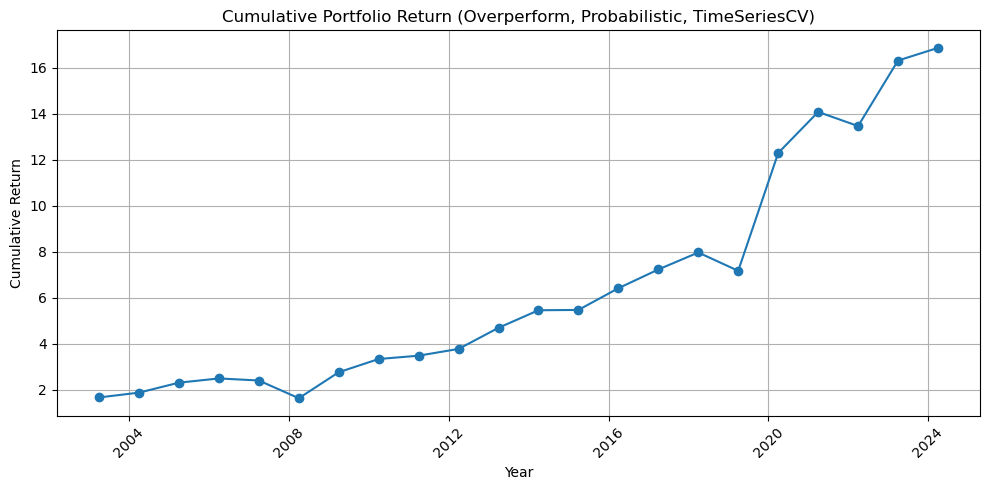

In [15]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(42)

# 1. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Define las features y prepara datos
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'target_12m_final','target_class']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Calcular distribución de retornos para calibración probabilística
return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
# Corregido: Usar todas las etiquetas (4 etiquetas para 4 intervalos)
y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

# Ajustar umbrales con una función logística aproximada
def logistic_prob(return_value):
    thresholds = [0.0, 0.05, 0.08]
    probs = np.zeros(len(return_labels))
    for i, thresh in enumerate(thresholds + [np.inf]):
        if i == 0:
            probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
        elif i == len(thresholds):
            probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
        else:
            probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
    return probs / probs.sum()  # Normalizar para que sumen 1

# 4. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.07,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        early_stopping_rounds=10
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 5. Clasificación probabilística
    prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
    predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
    predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

    # 6. DataFrame solo test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = predicted_classes
    for label in return_labels:
        df_test[f'prob_{label}'] = predicted_probs[label]
    df_test['fold'] = fold + 1

    # 7. Retorno del portfolio de Overperform (basado en probabilidad)
    for year, group in df_test.groupby('date'):
        overperf = group[group['prob_Overperform'] > 0.5]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 8. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 9. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



# Aproximamiento probabilísitco pero promediando semillas

Este código implementa un pipeline de aprendizaje automático para predecir los retornos financieros a 12 meses (`target_12m_final`) utilizando el modelo XGBoost, respetando la naturaleza temporal de los datos mediante la ordenación por fecha y el uso de `TimeSeriesSplit` con 5 divisiones para evitar fugas de información. Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, manejando valores faltantes mediante la sustitución de infinitos por `NaN` y filtrando filas incompletas. A diferencia de un enfoque determinista con umbrales fijos, se emplea una clasificación probabilística: los retornos predichos se transforman en probabilidades para las categorías "Negative", "Underperform", "Perform" y "Overperform" utilizando una función logística calibrada con la distribución histórica de los retornos. Los activos con una probabilidad superior al 50% de ser "Overperform" se seleccionan para formar un portafolio, cuyo retorno promedio y número de activos se calculan por fecha y fold. Para reducir la variabilidad observada al cambiar la semilla aleatoria (e.g., retornos del 400% con semilla 42 frente al 800% con semilla 43), se promedian los resultados sobre múltiples semillas (`[42, 43, 44, 45, 46]`), mejorando la robustez del modelo. Los resultados se agrupan por año, calculando el retorno acumulado, y se visualizan mediante un gráfico con `matplotlib`. Este enfoque probabilístico, combinado con el promedio de semillas, busca estabilizar las predicciones y ofrecer una estimación más fiable del rendimiento del portafolio.


         date  portfolio_return  n_stocks  cumulative_return
0  2003-03-31          0.488024      18.8           1.488024
1  2004-03-31          0.174134      64.8           1.747141
2  2005-03-31          0.242865      75.2           2.171459
3  2006-03-31          0.089121      77.8           2.364982
4  2007-03-31          0.003777      33.2           2.373914
5  2008-03-31         -0.318650      60.6           1.617467
6  2009-03-31          0.676175      49.8           2.711158
7  2010-03-31          0.212294      48.8           3.286722
8  2011-03-31          0.043378      49.0           3.429292
9  2012-03-31          0.102537      25.1           3.780921
10 2013-03-31          0.259704      44.2           4.762841
11 2014-03-31          0.169196      44.8           5.568693
12 2015-03-31          0.000746      43.6           5.572846
13 2016-03-31          0.197700      22.3           6.674597
14 2017-03-31          0.154122      37.0           7.703298
15 2018-03-31          0

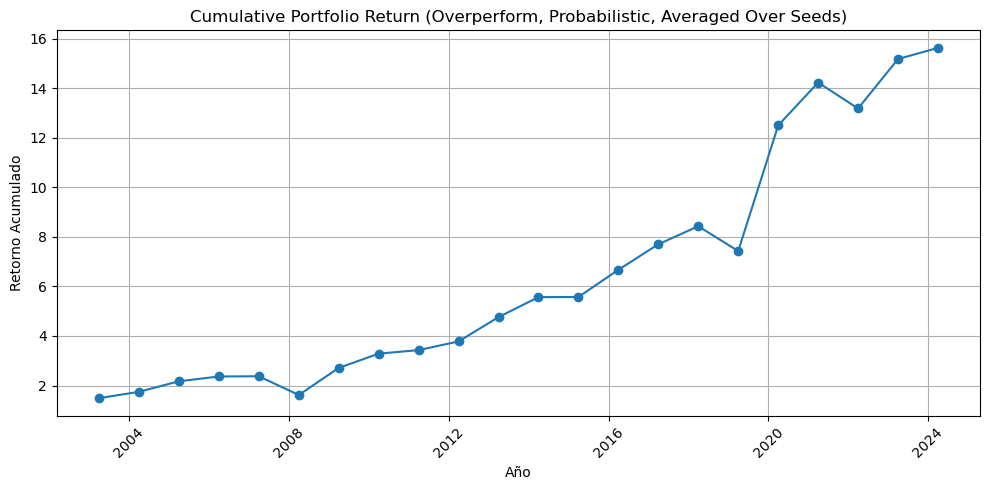

In [8]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Lista de semillas para promediar y fijar reproducibilidad
seeds = [42, 43, 44, 45, 46]
all_results = []

for seed in seeds:
    # Fijar semilla para cada iteración
    np.random.seed(seed)

    # 1. Ordena por fecha para respetar la temporalidad
    data_base = data_base.sort_values('date')

    # 2. Define las features y prepara datos
    features = [
        col for col in data_base.columns
        if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
        and not col.startswith('target')
    ]

    X = data_base[features].replace([np.inf, -np.inf], np.nan)
    y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X.loc[mask]
    y = y.loc[mask]
    data_filtered = data_base.loc[mask].copy()

    # 3. Calcular distribución de retornos para calibración probabilística
    return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
    return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
    y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
    y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

    # Ajustar umbrales con una función logística aproximada
    def logistic_prob(return_value):
        thresholds = [0.0, 0.05, 0.08]
        probs = np.zeros(len(return_labels))
        for i, thresh in enumerate(thresholds + [np.inf]):
            if i == 0:
                probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
            elif i == len(thresholds):
                probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
            else:
                probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
        return probs / probs.sum()  # Normalizar para que sumen 1

    # 4. Setup TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    result_list = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(

            n_jobs=1, # No paralelizar para evitar diferentes resultados por semilla 
            n_estimators=300,
            learning_rate=0.07,
            max_depth=4,  # Reducido para estabilidad
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=seed,  # Semilla específica por iteración
            early_stopping_rounds=10
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # 5. Clasificación probabilística
        prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
        predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
        predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

        # 6. DataFrame solo test
        df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
        df_test['predicted_return'] = y_pred
        df_test['predicted_class'] = predicted_classes
        for label in return_labels:
            df_test[f'prob_{label}'] = predicted_probs[label]
        df_test['fold'] = fold + 1

        # 7. Retorno del portfolio de Overperform (basado en probabilidad)
        for year, group in df_test.groupby('date'):
            overperf = group[group['prob_Overperform'] > 0.5]
            if len(overperf) > 0:
                portfolio_return = overperf['target_12m_final'].mean()
                n_stocks = len(overperf)
            else:
                portfolio_return = 0.0
                n_stocks = 0
            result_list.append({
                'date': year,
                'fold': fold + 1,
                'portfolio_return': portfolio_return,
                'n_stocks': n_stocks,
                'seed': seed  # Añadido para rastrear la semilla
            })

    # 8. DataFrame de resultados por semilla
    results = pd.DataFrame(result_list)
    results = results.sort_values(['date', 'fold'])
    all_results.append(results)

# 9. Promediar resultados sobre todas las semillas
all_results_df = pd.concat(all_results)
annual_results = all_results_df.groupby(['date']).agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, Averaged Over Seeds)")
plt.xlabel("Año")
plt.ylabel("Retorno Acumulado")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
start = 1998
end = 2025

for year in range(start, end):
    unique_tickers = data_base[data_base['date'] == f'{year}-03-31']['ticker'].nunique()
    print(f"Año {year}: {unique_tickers} tickers únicos")


Año 1998: 0 tickers únicos
Año 1999: 499 tickers únicos
Año 2000: 499 tickers únicos
Año 2001: 499 tickers únicos
Año 2002: 499 tickers únicos
Año 2003: 500 tickers únicos
Año 2004: 500 tickers únicos
Año 2005: 500 tickers únicos
Año 2006: 500 tickers únicos
Año 2007: 500 tickers únicos
Año 2008: 500 tickers únicos
Año 2009: 500 tickers únicos
Año 2010: 499 tickers únicos
Año 2011: 500 tickers únicos
Año 2012: 500 tickers únicos
Año 2013: 500 tickers únicos
Año 2014: 500 tickers únicos
Año 2015: 502 tickers únicos
Año 2016: 504 tickers únicos
Año 2017: 505 tickers únicos
Año 2018: 505 tickers únicos
Año 2019: 505 tickers únicos
Año 2020: 505 tickers únicos
Año 2021: 505 tickers únicos
Año 2022: 505 tickers únicos
Año 2023: 503 tickers únicos
Año 2024: 503 tickers únicos


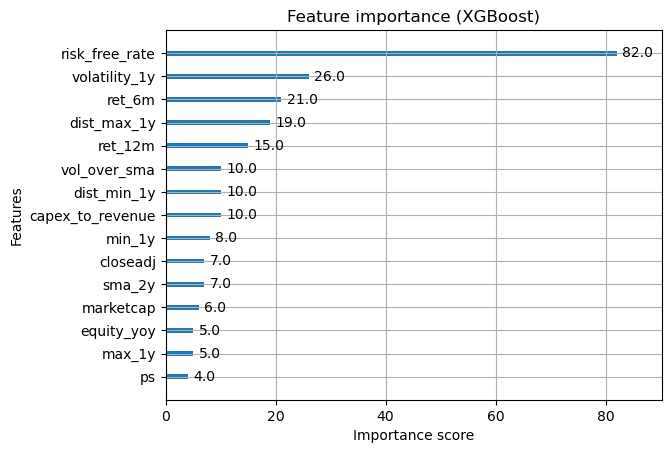

In [7]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=15)
plt.title("Feature importance (XGBoost)")
plt.show()


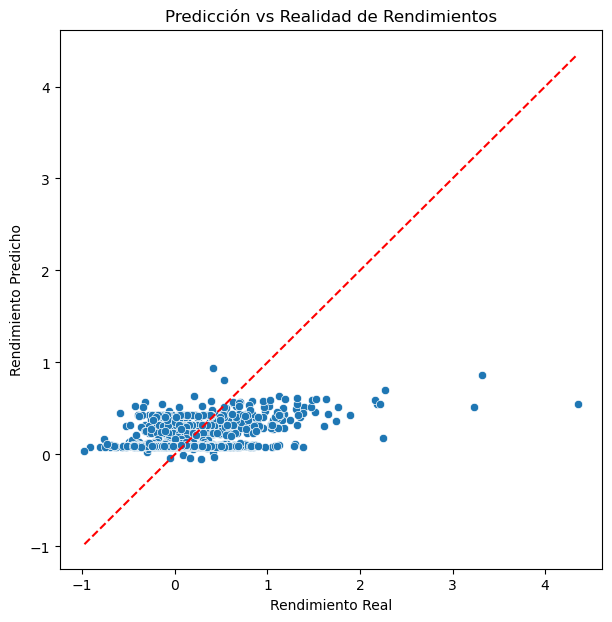

In [8]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Rendimiento Real')
plt.ylabel('Rendimiento Predicho')
plt.title('Predicción vs Realidad de Rendimientos') 
plt.show()


In [13]:
# Apply to test set predictions and real values
y_test_class = y_test.apply(sharpe_class)
y_pred_class = pd.Series(y_pred).apply(sharpe_class)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=["Underperform", "Normal", "Overperform"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under", "Normal", "Over"])
disp.plot()
plt.title("Confusion Matrix for Sharpe Ratio Classes")
plt.show()

print(classification_report(y_test_class, y_pred_class, digits=3))

NameError: name 'sharpe_class' is not defined

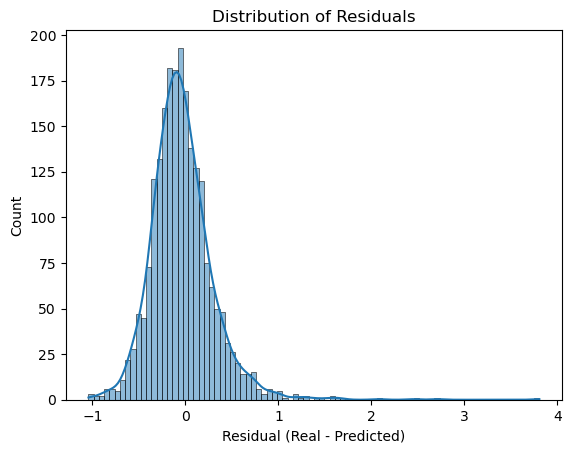

In [9]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Real - Predicted)")
plt.show()


In [10]:
results_df = data_base.loc[y_test.index, ['ticker', 'date']].copy()
results_df['sharpe_true'] = y_test
results_df['sharpe_pred'] = y_pred
results_df['sharpe_true_class'] = y_test_class.values
results_df['sharpe_pred_class'] = y_pred_class.values

over_df = results_df[results_df['sharpe_pred_class'] == 'Overperform']

over_df_sorted = over_df.sort_values(['date', 'ticker'])
display(over_df_sorted[['date', 'ticker']])


NameError: name 'y_test_class' is not defined

In [4]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap'],
      dtype='object')

In [ ]:
data_base.drop(columns=['ticker', 'cap_category','date'], inplace=True)

In [50]:
data_base.drop(columns=['pb_yoy'], inplace=True)

c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:42:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:42:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:42:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:42:13] WARNING: C:\actions-runner\_work\xgboost\xgboost

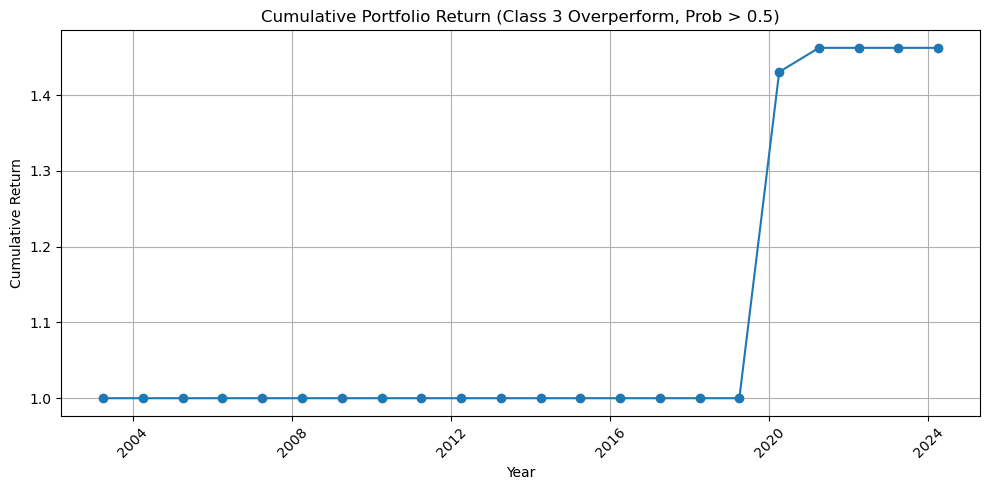

In [11]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(42)

# 1. Ordenar por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Definir las features y preparar datos
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'target_12m_final', 'close_adj']
    and not col.startswith('target')
]


X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Crear las clases (labels) multiclase como números directamente
return_bins = [-np.inf, 0.0, 0.05, 0.12, np.inf]  # Definir umbrales
y_binned = pd.cut(y, bins=return_bins, labels=False, include_lowest=True)
# Labels serán: 0=Negative, 1=Underperform, 2=Perform, 3=Overperform

# 4. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binned.iloc[train_idx], y_binned.iloc[test_idx]

    model = xgb.XGBClassifier(
        objective='multi:softprob',  # Multiclase probabilística
        num_class=4,                 # 4 clases
        n_estimators=300,
        learning_rate=0.07,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        early_stopping_rounds=10
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    probs = model.predict_proba(X_test)  # Probabilidades para cada clase

    # Clase 3 corresponde siempre a Overperform
    over_idx = 3
    over_probs = probs[:, over_idx]

    predicted_classes = model.predict(X_test)

    # 5. DataFrame solo test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_class'] = predicted_classes
    for i in range(probs.shape[1]):
        df_test[f'prob_class_{i}'] = probs[:, i]
    df_test['fold'] = fold + 1

    # 6. Retorno del portfolio de Overperform (basado en probabilidad)
    for year, group in df_test.groupby('date'):
        overperf = group[group[f'prob_class_{over_idx}'] > 0.8]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 7. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 8. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 9. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Class 3 Overperform, Prob > 0.5)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



=== Top 20 Features Más Importantes ===
               feature  importance
34      risk_free_rate    0.095133
50        vol_over_sma    0.061140
3               sma_1y    0.036522
33             ret_12m    0.036151
5        volatility_1y    0.030602
32              ret_6m    0.030510
49         dist_min_1y    0.026048
46          ret_6m_vol    0.024951
48         dist_max_1y    0.023329
7                  eps    0.022124
47            sma_diff    0.021881
35  signed_log_revenue    0.020844
31            closeadj    0.019471
1               max_1y    0.019213
2               min_1y    0.019013
11            evebitda    0.017402
43           fcf_yield    0.017260
45         ret_12m_vol    0.017237
37     signed_log_ebit    0.016885
44                  ps    0.016831


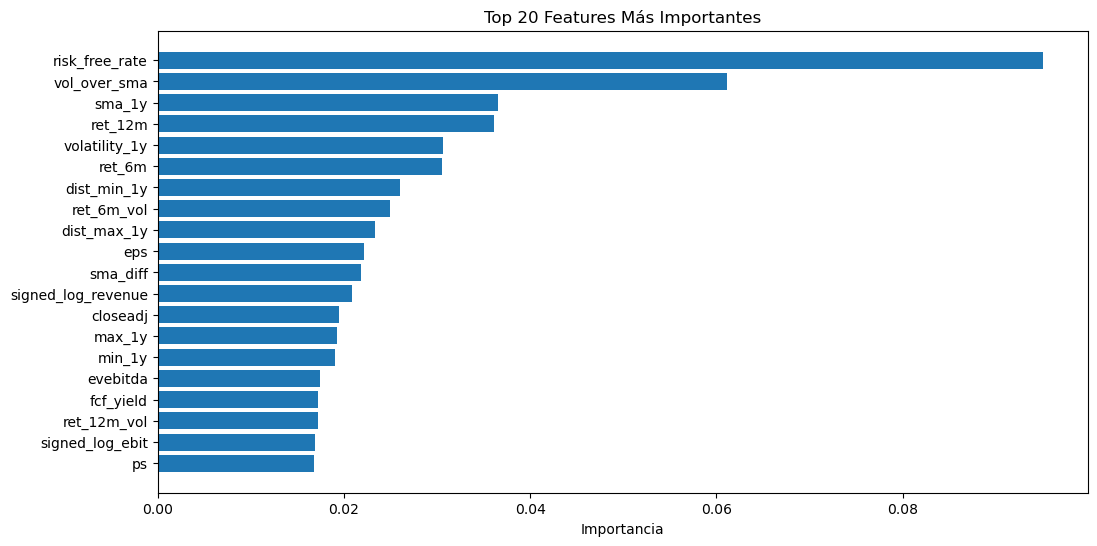

In [11]:
import matplotlib.pyplot as plt

# 1. Importancia de características
feature_importance = model.feature_importances_

# 2. Crear un DataFrame ordenado
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# 3. Mostrar las top 20 más importantes
print("\n=== Top 20 Features Más Importantes ===")
print(importance_df.head(20))

# 4. Gráfico de importancia
plt.figure(figsize=(12, 6))
plt.barh(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.xlabel("Importancia")
plt.title("Top 20 Features Más Importantes")
plt.gca().invert_yaxis()
plt.show()



=== Empresas Seleccionadas por Año ===
           date  fold ticker  stock_return  prob_overperform
8    2003-03-31     1    EOP      0.219334          0.914554
80   2003-03-31     1    AES      1.355972          0.910461
71   2003-03-31     1    GP1      1.473815          0.908516
1    2003-03-31     1    WWY      0.062883          0.906903
15   2003-03-31     1    PFE      0.145642          0.906742
...         ...   ...    ...           ...               ...
1856 2024-03-31     5   VTRS     -0.238503          0.531247
1851 2024-03-31     5    DOC      0.144296          0.515232
1850 2024-03-31     5     RF      0.078733          0.506051
1855 2024-03-31     5    KMI      0.636944          0.502921
1857 2024-03-31     5     IP      0.418166          0.502478

[1860 rows x 5 columns]


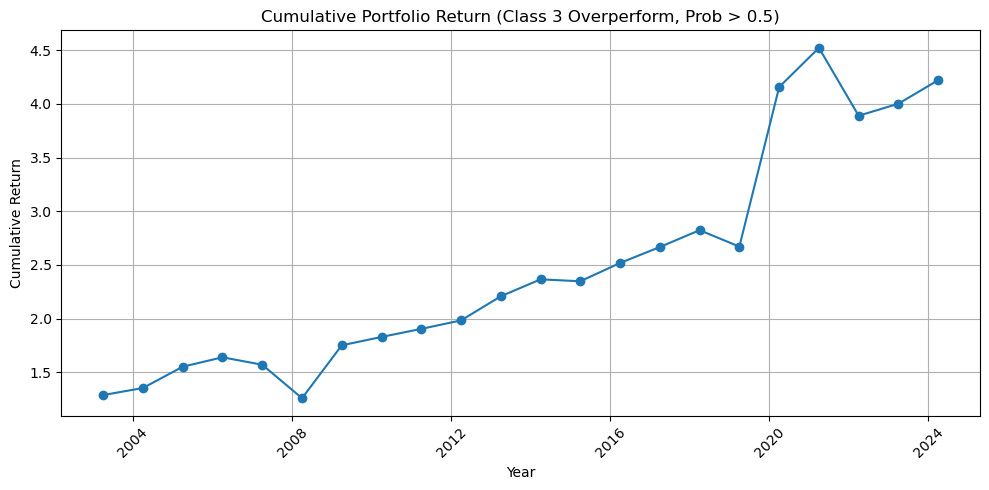

In [12]:
selected_stocks = []  # <- Lista para guardar stocks seleccionados

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    ...
    # Tu modelo, tu predicción...
    
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_class'] = predicted_classes
    for i in range(probs.shape[1]):
        df_test[f'prob_class_{i}'] = probs[:, i]
    df_test['fold'] = fold + 1

    for year, group in df_test.groupby('date'):
        overperf = group[group[f'prob_class_{over_idx}'] > 0.5]
        
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0

        # --- Save stock-level info
        for idx, row in overperf.iterrows():
            selected_stocks.append({
                'date': row['date'],
                'fold': fold + 1,
                'ticker': row['ticker'],
                'stock_return': row['target_12m_final'],
                'prob_overperform': row[f'prob_class_{over_idx}']
            })

        # Save portfolio summary
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 7. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 8. DataFrame de acciones seleccionadas
selected_stocks_df = pd.DataFrame(selected_stocks)
selected_stocks_df = selected_stocks_df.sort_values(['date', 'fold', 'prob_overperform'], ascending=[True, True, False])

# 9. Métrica ANUAL
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# Mostrar top seleccionados
print("\n=== Empresas Seleccionadas por Año ===")
print(selected_stocks_df)

# 11. Gráfico
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Class 3 Overperform, Prob > 0.5)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


         date  portfolio_return  n_stocks
0  2003-03-31          0.286767    109.00
1  2004-03-31          0.051255     67.00
2  2005-03-31          0.146654      3.50
3  2006-03-31          0.056527      2.50
4  2007-03-31         -0.042303     37.00
5  2008-03-31         -0.198759    101.00
6  2009-03-31          0.392126      7.00
7  2010-03-31          0.044381      3.00
8  2011-03-31          0.041220      5.00
9  2012-03-31          0.041562     70.75
10 2013-03-31          0.113392     35.50
11 2014-03-31          0.071417      3.50
12 2015-03-31         -0.007566      4.00
13 2016-03-31          0.072716     53.25
14 2017-03-31          0.058970     71.00
15 2018-03-31          0.058866      3.50
16 2019-03-31         -0.054299      2.50
17 2020-03-31          0.557116     67.25
18 2021-03-31          0.087781    104.00
19 2022-03-31         -0.139903      4.50
20 2023-03-31          0.028827      3.00
21 2024-03-31          0.054952      5.00

Average number of stocks per year

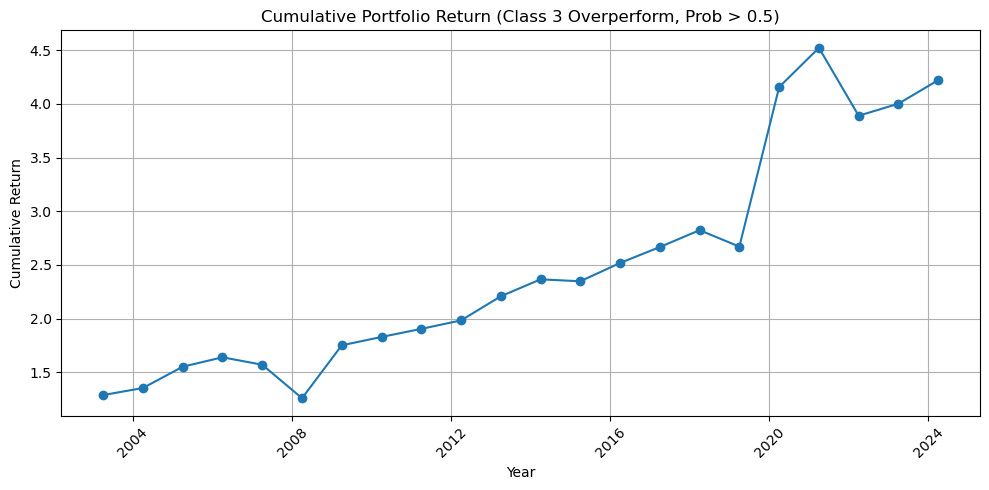

In [13]:
# 8. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

print(annual_results)

# Check average number of stocks selected per year
print("\nAverage number of stocks per year:")
print(annual_results[['date', 'n_stocks']])

# Check average portfolio returns per year
print("\nAverage portfolio return per year:")
print(annual_results[['date', 'portfolio_return']])

# Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Class 3 Overperform, Prob > 0.5)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

all_y_true = []
all_y_pred = []

# New evaluation loop
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binned.iloc[train_idx], y_binned.iloc[test_idx]

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        n_estimators=300,
        learning_rate=0.07,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        early_stopping_rounds=10
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Evaluate classification performance
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, digits=3))

print("\nConfusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))


c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:38:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:38:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:38:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:38:56] WARNING: C:\actions-runner\_work\xgboost\xgboost


Classification Report:
              precision    recall  f1-score   support

           0      0.742     0.602     0.665      3664
           1      0.294     0.013     0.024       783
           2      0.000     0.000     0.000       481
           3      0.680     0.916     0.781      5532

    accuracy                          0.696     10460
   macro avg      0.429     0.383     0.367     10460
weighted avg      0.642     0.696     0.647     10460


Confusion Matrix:
[[2206   14    0 1444]
 [ 207   10    1  565]
 [ 102    4    0  375]
 [ 459    6    0 5067]]
